<a href="https://colab.research.google.com/github/filippovaldettaro/3Drotation/blob/master/GaussianDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import math

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.optim as optim

In [2]:
def generate_gaussian(mean, std, grid_size, grid_scale=1, max_value=None, noise_std=0):
    if max_value is None:
        max_value = 1/(std*math.sqrt(2*math.pi))
    
    x = torch.arange(start=-grid_size, end=grid_size+grid_scale, step=grid_scale)
    z = (x-mean)/std
    
    return max_value*torch.exp(-z**2/2) + torch.normal(torch.zeros_like(z), noise_std)


In [3]:
input_size = 10
grid_scale = 0.5

class GaussiansDataset(Dataset):
    
    def __init__(self, cutoff, size):
        self.gaussians = []
        self.labels = []
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.gaussians[idx], self.labels[idx]

class GaussiansScaled(GaussiansDataset):

    def __init__(self, cutoff,  size, noise_std=0):
        super(GaussiansDataset, self).__init__()

        self.gaussians = []
        self.labels = []

        self.cutoff = cutoff
        self.size = size

        # Generate the gaussians - here keep std constant and sample scale from U(0,1)

        for i in range(self.size):
            scale = torch.rand(1)
            self.gaussians.append(generate_gaussian(0,1,10,0.5, scale))
            self.labels.append(int(self.cutoff < scale))

class GaussiansWidth(GaussiansDataset):

    def __init__(self, cutoff,  size, noise_std=0):
        super(GaussiansDataset, self).__init__()

        self.gaussians = []
        self.labels = []

        self.cutoff = cutoff
        self.size = size

        # Generate the gaussians - here keep scale constant and sample std from U(0,1)

        for i in range(self.size):
            std = torch.rand(1)
            self.gaussians.append(generate_gaussian(0,std,10,0.5, 1))
            self.labels.append(int(self.cutoff < std))


In [5]:
train_loader = torch.utils.data.DataLoader(GaussiansScaled(0.5, 60000, noise_std=0.1), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(GaussiansScaled(0.5, 10000, noise_std=0.1), batch_size=64, shuffle=True)

In [6]:
#prunable layers

import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair

class Linear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__(in_features, out_features, bias)        
        self.register_buffer('weight_mask', torch.ones(self.weight.shape), persistent=False)
        if self.bias is not None:
            self.register_buffer('bias_mask', torch.ones(self.bias.shape), persistent=False)

    def forward(self, input):
        W = self.weight_mask * self.weight
        if self.bias is not None:
            b = self.bias_mask * self.bias
        else:
            b = self.bias
        return F.linear(input, W, b)


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

torch.manual_seed(123);

'''class BiPoCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # need to check of difference of padding option 
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=7,kernel_size=2, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(7, 14, kernel_size=2, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(14 * 768, 64) # 2x max pooling gives 250 depth with 14 filters
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 14 * 768) 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        probs = F.softmax(out, dim=1)
        return probs
'''
class LinearLayers(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.lin1 = Linear(int(2*input_size/grid_scale)+1, 10)
        self.act1 = nn.ReLU()
        self.lin2 = Linear(10, 10)
        self.act2 = nn.ReLU()
        self.lin3 = Linear(10, 1)
        self.act3 = nn.Sigmoid()
    
    def forward(self, x):
        out = self.act1(self.lin1(x))
        out = self.act2(self.lin2(out))
        out = self.act3(self.lin3(out))
        return out

In [8]:
from tqdm import tqdm 
from copy import deepcopy


def train(model, train_loader, loss_fn, optimizer, num_epochs):
    losses = []
    for epoch in range(num_epochs):#tqdm(range(num_epochs)):
        model.train()
        
        for gaussians, labels in train_loader:
            #classification with a single neuron
            output = model(gaussians)
            
            loss = loss_fn(output, labels.unsqueeze(-1).float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    return losses



#losses = train(model, train_loader, loss_fn, optimizer, num_epochs)
#plt.plot(losses)

In [9]:
def test(model, test_loader):
    model.eval()

    y_true = None
    y_pred = None

    with torch.no_grad():
        for gaussians, labels in test_loader:
            if y_true is None:
                y_pred = torch.round(model(gaussians).flatten())
                y_true = labels.float()
            else:
            #might want to use something other than just classification accuracy?
                y_pred = torch.cat((y_pred, torch.round(model(gaussians).flatten())))
                y_true = torch.cat((y_true, labels.float()))

        print(max(y_pred))
    return torch.mean((y_pred == y_true).float())

#test(model, test_loader)

tensor(1.)
tensor(0.9999)


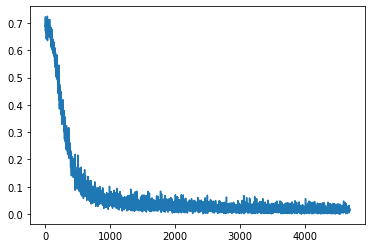

In [10]:
model = LinearLayers(input_size)
num_epochs = 5
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters())

'''losses = []
for epoch in range(num_epochs):#tqdm(range(num_epochs)):
    model.train()
    
    for gaussians, labels in train_loader:
        #classification with a single neuron
        output = model(gaussians)
        
        loss = loss_fn(output, labels.unsqueeze(-1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
'''
losses = train(model, train_loader, loss_fn, optimizer, num_epochs)
print(test(model, test_loader))
plt.plot(losses)

In [11]:
model = LinearLayers(input_size)

In [12]:
#train-prune loop
from collections import OrderedDict

def prune_score(x):
    return x**2

num_epochs = 5
loss_fn = nn.BCELoss()

param_proportions = np.linspace(0.1, 1, 1)
prune_iterations = 5

models = []
performance = []
for overall_fraction in (param_proportions):
    print("proportion of retained parameters: ", overall_fraction)

    model = LinearLayers(input_size)
       
    initial_model_dict = deepcopy(model.state_dict())
    
    
    for iteration in range(1, prune_iterations+1):
        print("iteration", iteration, " of ", prune_iterations)
        iter_prune_fraction = overall_fraction**(iteration/prune_iterations) #gradually reach the overall pruning desired

        compression = 1/iter_prune_fraction
        list_of_params = torch.cat([model.state_dict()[layer].flatten() for layer in model.state_dict()])
        cutoff_parameter_rank = int(len(list_of_params)/compression)
        cutoff_score = torch.sort(prune_score(list_of_params), descending=True).values[cutoff_parameter_rank-1]

        if iteration > 1:
            #reinitialise weights
            model.load_state_dict(new_init_dict)
            #update mask
            for name, module in model.named_modules():
                if name+".weight" in prune_mask_dict:
                    module.weight_mask = prune_mask_dict[name+".weight"]
                elif name+".bias" in prune_mask_dict:
                    module.bias_mask = prune_mask_dict[name+".bias"]

        optimizer = optim.Adam(model.parameters())      #REALLY IMPORTANT!!!!!!

        losses = train(model, train_loader, loss_fn, optimizer, num_epochs)

        prune_mask_dict = {}
        for layer in model.state_dict():
            prune_mask_dict[layer] = prune_score(model.state_dict()[layer]) >= cutoff_score

        new_init_dict = OrderedDict()
        for layer in model.state_dict():
            new_init_dict[layer] = initial_model_dict[layer] * prune_mask_dict[layer]


    models.append(model)
    performance.append(test(model, test_loader))

proportion of retained parameters:  0.1
iteration 1  of  5
iteration 2  of  5
iteration 3  of  5
iteration 4  of  5
iteration 5  of  5
tensor(1.)


In [13]:
performance

[tensor(0.9987)]

In [14]:
from PIL import Image, ImageDraw
import numpy as np

def drawcircle(img, x,y,r):
    draw = ImageDraw.Draw(img)
    leftUpPoint = (x-r, y-r)
    rightDownPoint = (x+r, y+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, fill=(255,0,0,255))

def drawline(img, fill, x1,y1, x2,y2):
    draw = ImageDraw.Draw(img)
    start = (x1,y1)
    end = (x2,y2)
    draw.line((x1,y1,x2,y2), fill=fill)
    
def visualiseMLP(model, w, h, neuron_size=5):
    blank = 100*np.ones((h, w, 3), dtype=np.uint8)
    img = Image.fromarray(blank, 'RGB')
    layers = 1
    layer_widths = []
    weights = []
    max_weight = 0
    masks = []
    first_layer = True
    for name, module in list(model.named_modules()):
        if name+".weight" in model.state_dict():
            layers+=1
            if first_layer:
                layer_widths.append(list(module.parameters())[0].shape[1])
                first_layer = False
            layer_widths.append(list(module.parameters())[0].shape[0])
            weights.append(model.state_dict()[name+".weight"])
            max_weight = max(max_weight, torch.max(model.state_dict()[name+".weight"]))
            masks.append(module.weight_mask)
    
    layer_spacing = int(w/(layers+1))
    for layer in range(layers-1):
        in_shape, out_shape = layer_widths[layer], layer_widths[layer+1]
        in_neurons_spacing, out_neurons_spacing = int(h/(in_shape+1)), int(h/(out_shape+1))
        mask = masks[layer]
        out_shape, in_shape = mask.shape
        if layer == 0:
            x = layer_spacing
            y = in_neurons_spacing
            for neuron in range(in_shape):
                drawcircle(img, x,y, neuron_size)
                y += in_neurons_spacing
        x = layer_spacing*(2+layer)
        y = out_neurons_spacing
        for neuron in range(out_shape):
            drawcircle(img, x,y, neuron_size)
            y += out_neurons_spacing
        for out_neuron in range(out_shape):
            x_out, y_out = (layer+2)*layer_spacing, (out_neuron+1)*out_neurons_spacing
            for in_neuron in range(in_shape):
                x_in, y_in = (layer+1)*layer_spacing, (in_neuron+1)*in_neurons_spacing
                if mask[out_neuron, in_neuron]:
                    relative_size = float(weights[layer][out_neuron, in_neuron])/max_weight
                    relative_colour = int(255*relative_size)
                    fill = (int(relative_colour/3), 0, relative_colour)
                    drawline(img, fill, x_in,y_in,x_out,y_out)

    return img

In [15]:
imgs = [visualiseMLP(model, 512, 1024) for model in models]
print(torch.sum(models[0].lin1.weight_mask))

tensor(75)


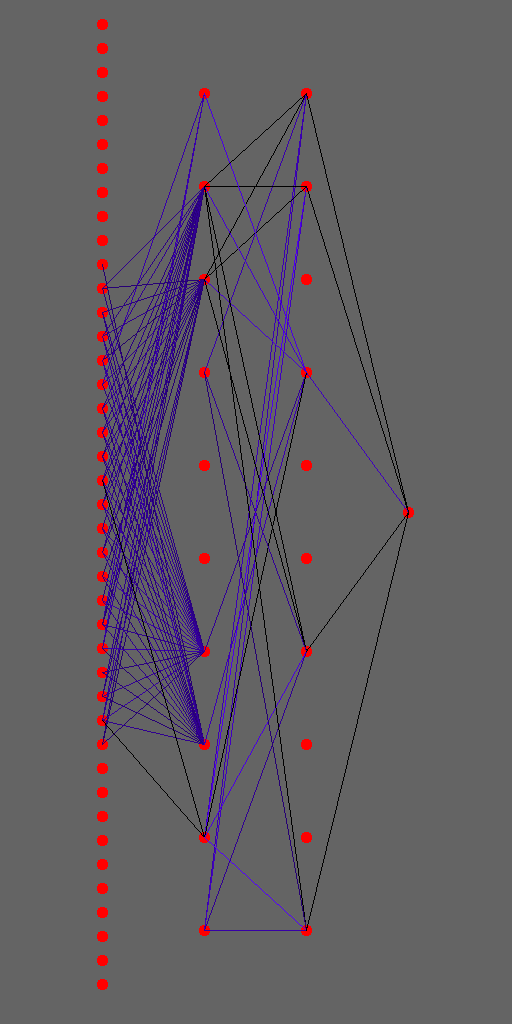

In [16]:
imgs[0]

tensor([0.9999], grad_fn=<SelectBackward>)


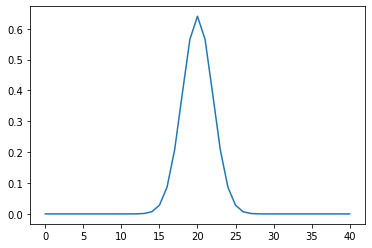

In [17]:
#plot gaussians of a particular label

num_samples = 10
data_iter = iter(train_loader)
for i in range(num_samples):
    batch_gaussian, batch_label = next(data_iter)
    #print(batch_gaussian[i])
    if batch_label[i] == 1:
        plt.plot(batch_gaussian[i])
        print(model(batch_gaussian)[i])

In [18]:
model.eval()

output = model(batch_gaussian)
print(output.shape)
print(batch_label.shape)
worst_performance = torch.argmax(abs(output-batch_label.unsqueeze(-1)))
print(output[worst_performance])
print(batch_label[worst_performance])
print(max(batch_gaussian[worst_performance]))

torch.Size([64, 1])
torch.Size([64])
tensor([0.6244], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.5039)


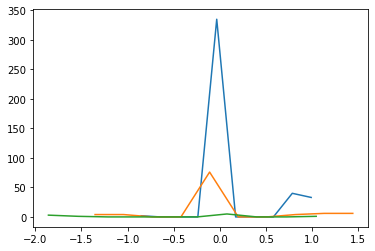

In [19]:
#weight distribution

layers = int(len(list(model.parameters()))/2)

for layer in range(layers):
    weights = list(model.parameters())[2*layer].data
    y, x = np.histogram(weights)
    avg_x = np.zeros_like(y).astype(float)
    for i in range(len(avg_x)):
        avg_x[i] = (x[i]+x[i+1])/2

    plt.plot(avg_x, y)


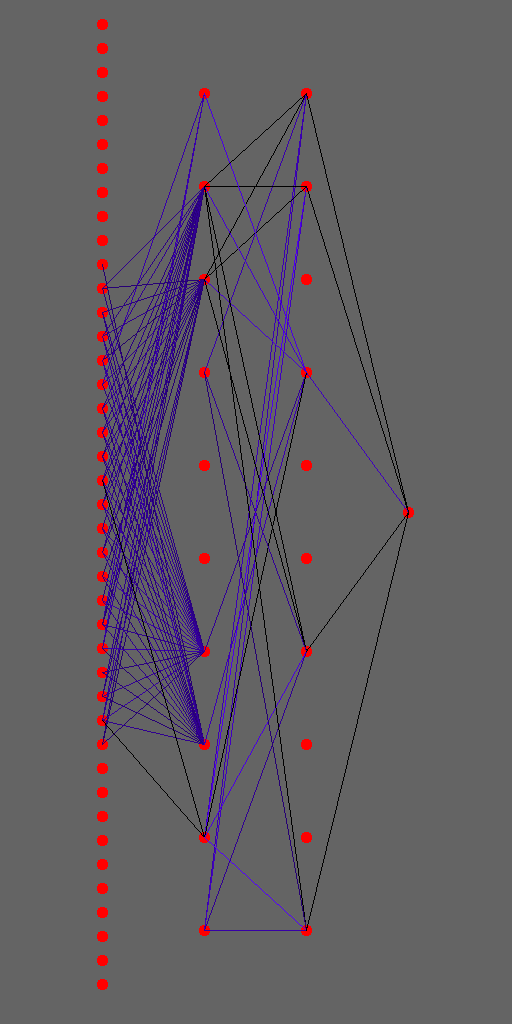

In [20]:
visualiseMLP(model, 512, 1024)

In [21]:
for i,j in ((model.named_modules())):
    print("OMOMOM")
    print(i)
    print(j)

OMOMOM

LinearLayers(
  (lin1): Linear(in_features=41, out_features=10, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=10, out_features=1, bias=True)
  (act3): Sigmoid()
)
OMOMOM
lin1
Linear(in_features=41, out_features=10, bias=True)
OMOMOM
act1
ReLU()
OMOMOM
lin2
Linear(in_features=10, out_features=10, bias=True)
OMOMOM
act2
ReLU()
OMOMOM
lin3
Linear(in_features=10, out_features=1, bias=True)
OMOMOM
act3
Sigmoid()
